In [1]:
!pip install pyshark
!pip install py7zr
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import os
from util.pandas_util import pcap_to_df
import pyshark
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import plot_tree
from sklearn.utils import resample
import xgboost as xgb
from trustee import ClassificationTrustee
import matplotlib.pyplot as plt
import zipfile
import shutil
import py7zr

In [3]:
DATASET_DIR = './'

# unzip and extract .7z files
def extract_7z_files(dataset_dir):
    for file in os.listdir(dataset_dir):
        if file.endswith(".7z"):
            filepath = os.path.join(dataset_dir, file)
            extract_dir = os.path.join(dataset_dir, file[:-3])
            with py7zr.SevenZipFile(filepath, mode='r') as archive:
                archive.extractall(path=extract_dir)
            print(f"Extracted: {file}")

# feature extraction
def extract_features(pcap_file):
    """
    Extract basic features from a .pcap file.
    Features include packet count, average packet size, and protocol distribution.
    """
    cap = pyshark.FileCapture(pcap_file)
    packet_count = 0
    total_packet_size = 0
    protocol_counts = {}
    
    for packet in cap:
        packet_count += 1
        total_packet_size += int(packet.length)
        protocol = packet.highest_layer
        protocol_counts[protocol] = protocol_counts.get(protocol, 0) + 1
    
    cap.close()
    avg_packet_size = total_packet_size / packet_count if packet_count > 0 else 0
    features = {
        'packet_count': packet_count,
        'avg_packet_size': avg_packet_size,
        **protocol_counts
    }
    return features

In [65]:
# extract_7z_files(DATASET_DIR)

# parse benign vs malignant
benign_dir = os.path.join(DATASET_DIR, "benign")
malignant_dir = os.path.join(DATASET_DIR, "malignant")

# dataframe
master_df = pd.DataFrame()

desired_files = ['Miuref.pcap']
for label, category_dir in enumerate([benign_dir, malignant_dir]):
    for root, _, files in os.walk(category_dir):
        for file in files:
            if file.endswith(".pcap") and file in desired_files:
                pcap_path = os.path.join(root, file)
                try:
                    df = pcap_to_df(pcap_path)
                    
                    df['label'] = label  # 0 for benign, 1 for malignant
                    
                    master_df = pd.concat([master_df, df], ignore_index=True)
                    
                    print(f"Processed {file} successfully")
                except Exception as e:
                    print(f"Error processing {pcap_path}: {e}")

Processed Miuref.pcap successfully


In [3]:
# master_df.to_csv('miuref.csv', encoding='utf-8', index=False)
master_df = pd.read_csv('new_master_df.csv', low_memory=False)

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.width', None)

# preprocess df
master_df['sport'] = master_df['tcp_sport'].combine_first(master_df['udp_sport'])
master_df['dport'] = master_df['tcp_dport'].combine_first(master_df['udp_dport'])
master_df = master_df.drop(columns=['tcp_sport', 'udp_sport', 'tcp_dport', 'udp_dport'])

master_df = master_df.dropna(axis=1, how='all')

# display master df
master_df.head()

,version,ihl,tos,len,id,flags,frag,ttl,proto,chksum,src,dst,options,time,tcp_seq,tcp_ack,tcp_dataofs,tcp_reserved,tcp_flags,tcp_window,tcp_chksum,tcp_urgptr,tcp_options,udp_len,udp_chksum,label,sport,dport
0,4,5,0,958,39262,DF,0,32,17,61794,1.1.58.254,1.2.143.109,0,188027.032158,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,938.0,19540.0,0,16403.0,16403.0
1,4,5,0,274,39861,DF,0,32,17,52399,1.1.247.138,1.2.247.232,0,188027.032159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,93.0,0,16403.0,16403.0
2,4,5,0,274,45810,DF,0,32,17,5016,1.1.72.112,1.2.72.222,0,188027.032160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,45159.0,0,16403.0,16403.0
3,4,5,0,209,55387,DF,0,32,17,47336,1.2.29.161,1.1.169.52,0,188027.032161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,189.0,55115.0,0,16403.0,16403.0
4,4,5,0,958,10385,DF,0,32,17,16713,1.1.245.107,1.2.245.230,0,188027.032160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,938.0,59430.0,0,16403.0,16403.0


In [5]:
dtypes = {
    'version': 'Int64',       
    'ihl': 'Int64',
    'tos': 'Int64', 
    'len': 'Int64',
    'id': 'Int64',
    'flags': 'string',
    'frag': 'Int64',
    'ttl': 'Int64',
    'proto': 'Int64',
    'chksum': 'Int64',       
    'src': 'string', 
    'dst': 'string',
    'options': 'Int64', 
    'time': 'float',
    'sport': 'Int64',
    'dport': 'Int64',  
    'udp_len': 'Int64', 
    'udp_chksum': 'Int64', 
    'label': 'int64'
}

master_df = master_df.astype(dtypes)
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296528 entries, 0 to 296527
Data columns (total 28 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   version       296528 non-null  Int64  
 1   ihl           296528 non-null  Int64  
 2   tos           296528 non-null  Int64  
 3   len           296528 non-null  Int64  
 4   id            296528 non-null  Int64  
 5   flags         206400 non-null  string 
 6   frag          296528 non-null  Int64  
 7   ttl           296528 non-null  Int64  
 8   proto         296528 non-null  Int64  
 9   chksum        296528 non-null  Int64  
 10  src           296528 non-null  string 
 11  dst           296528 non-null  string 
 12  options       296528 non-null  Int64  
 13  time          296528 non-null  float64
 14  tcp_seq       245744 non-null  float64
 15  tcp_ack       245744 non-null  float64
 16  tcp_dataofs   245744 non-null  float64
 17  tcp_reserved  245744 non-null  float64
 18  tcp_

In [6]:
master_df[['sport', 'dport', 'udp_len', 'udp_chksum']] = master_df[['sport', 'dport', 'udp_len', 'udp_chksum']].fillna(-1)

In [7]:
master_df['tcp_flags'].unique()

array([nan, 'S', 'SA', 'A', 'PA', 'FPA', 'FA', 'RA', 'R'], dtype=object)

In [8]:
flows = master_df.groupby(['src', 'dst']).agg({
    'len': ['sum', 'mean', 'count', 'max', 'min'],
    'ttl': ['mean', 'std'],
    'time': [lambda x: np.ptp(pd.to_numeric(x)), # flow duration
             lambda x: len(x) / np.ptp(pd.to_numeric(x)) if np.ptp(pd.to_numeric(x)) > 0 else 0], # packets per second
    'tcp_flags': [
            lambda x: x.str.contains('S').sum() if x.dtype == 'object' else 0,
            lambda x: x.str.contains('F').sum() if x.dtype == 'object' else 0, # count FIN flags
            lambda x: x.str.contains('R').sum() if x.dtype == 'object' else 0,
        ],
    'tcp_window': ['mean', 'std'],
    'label': 'first'
})
flows.columns = ['_'.join(col).strip() for col in flows.columns.values]
flows['bytes_per_packet'] = flows['len_sum'] / flows['len_count']
flows = flows[flows['len_sum'] >= 5]

In [9]:
# remove src and dst
flows = flows.reset_index()
flows = flows.drop(['src', 'dst'], axis=1)

In [10]:
flows.describe()

,len_sum,len_mean,len_count,len_max,len_min,ttl_mean,ttl_std,time_<lambda_0>,time_<lambda_1>,tcp_flags_<lambda_0>,tcp_flags_<lambda_1>,tcp_flags_<lambda_2>,tcp_window_mean,tcp_window_std,label_first,bytes_per_packet
count,3.512800e+04,35128.000000,35128.000000,35128.000000,35128.000000,35128.00000,5936.000000,35128.000000,3.512800e+04,35128.000000,35128.000000,35128.000000,29106.000000,5910.000000,35128.000000,35128.000000
mean,1.548918e+03,364.858937,8.441357,414.286153,334.097301,32.22542,0.041858,163.105308,2.844902e+04,2.833381,0.249829,0.852454,26177.794273,243.100104,0.003758,364.858937
std,6.163983e+04,395.999308,336.449523,453.042286,396.495773,4.61706,1.724587,7593.480595,2.106067e+05,219.697366,7.674547,69.927067,16412.793114,1176.899909,0.061186,395.999308
min,5.200000e+01,40.000000,1.000000,40.000000,40.000000,1.00000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,3.539902,0.000000,0.000000,40.000000
25%,5.200000e+01,52.000000,1.000000,52.000000,52.000000,32.00000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,18824.000000,0.000000,0.000000,52.000000
50%,2.090000e+02,209.000000,1.000000,209.000000,52.000000,32.00000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,18824.000000,0.000000,0.000000,209.000000
75%,6.860000e+02,675.000000,1.000000,686.000000,654.000000,32.00000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,30408.000000,0.000000,0.000000,675.000000
max,8.244166e+06,1482.647031,32568.000000,2391.000000,1457.000000,255.00000,97.000000,516109.481835,2.000043e+06,32568.000000,1334.000000,7364.000000,65535.000000,30070.496115,1.000000,1482.647031


In [11]:
majority = flows[flows['label_first'] == 0]
minority = flows[flows['label_first'] == 1]

majority_downsampled = resample(majority, 
                              replace=False, 
                              n_samples=len(minority),
                              random_state=42) 

# balance flow df
balanced_df = pd.concat([majority_downsampled, minority])
balanced_df['label_first'].value_counts()

0    132
1    132
Name: label_first, dtype: int64

In [12]:
X = balanced_df.drop(['label_first'], axis=1)
y = balanced_df['label_first']

X = X.replace([np.inf, -np.inf], np.nan)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
flows.head()

,len_sum,len_mean,len_count,len_max,len_min,ttl_mean,ttl_std,time_<lambda_0>,time_<lambda_1>,tcp_flags_<lambda_0>,tcp_flags_<lambda_1>,tcp_flags_<lambda_2>,tcp_window_mean,tcp_window_std,label_first,bytes_per_packet
0,52,52.0,1,52,52,32.0,NaN,0.0,0.0,0,0,0,18824.0,NaN,0,52.0
1,52,52.0,1,52,52,32.0,NaN,0.0,0.0,0,1,0,65535.0,NaN,0,52.0
2,274,274.0,1,274,274,32.0,NaN,0.0,0.0,0,0,0,NaN,NaN,0,274.0
3,52,52.0,1,52,52,32.0,NaN,0.0,0.0,0,0,0,28960.0,NaN,0,52.0
4,274,274.0,1,274,274,32.0,NaN,0.0,0.0,0,0,0,NaN,NaN,0,274.0


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# uncomment for random forest classifier
# clf = RandomForestClassifier(
#     n_estimators=10,
#     max_depth=3,
#     min_samples_split=2,
#     min_samples_leaf=1,
#     max_features='sqrt',
#     random_state=42
# )

clf = xgb.XGBClassifier(
    max_depth=3,
    learning_rate=0.1,
    n_estimators=100,
    objective='binary:logistic',
    colsample_bytree=0.6,
    colsample_bylevel=0.6,
    scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
    random_state=42
)

clf.fit(X_train_scaled, y_train)

y_pred = clf.predict(X_train_scaled)
print(classification_report(y_train, y_pred))

X_test_scaled = scaler.transform(X_test)
y_pred = clf.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        80
           1       1.00      1.00      1.00        78

    accuracy                           1.00       158
   macro avg       1.00      1.00      1.00       158
weighted avg       1.00      1.00      1.00       158

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        52
           1       1.00      1.00      1.00        54

    accuracy                           1.00       106
   macro avg       1.00      1.00      1.00       106
weighted avg       1.00      1.00      1.00       106



In [14]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': clf.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))


Top 10 Most Important Features:
                 feature  importance
7        time_<lambda_0>    0.307922
5               ttl_mean    0.240538
2              len_count    0.228050
9   tcp_flags_<lambda_0>    0.072983
4                len_min    0.059073
8        time_<lambda_1>    0.051880
13        tcp_window_std    0.021480
0                len_sum    0.011267
6                ttl_std    0.006457
12       tcp_window_mean    0.000349


264
Training score of pruned DT: 1.0
Model explanation global fidelity report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        80
           1       0.49      1.00      0.66        78

    accuracy                           0.49       158
   macro avg       0.25      0.50      0.33       158
weighted avg       0.24      0.49      0.33       158

Model explanation score report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        80
           1       0.49      1.00      0.66        78

    accuracy                           0.49       158
   macro avg       0.25      0.50      0.33       158
weighted avg       0.24      0.49      0.33       158



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `z

[Text(0.5, 0.75, 'time_<lambda_0> <= -0.238\ngini = 0.5\nsamples = 130\nvalue = [64, 66]\nclass = malignant'),
 Text(0.25, 0.25, 'gini = 0.0\nsamples = 64\nvalue = [64, 0]\nclass = benign'),
 Text(0.375, 0.5, 'True  '),
 Text(0.75, 0.25, 'gini = 0.0\nsamples = 66\nvalue = [0, 66]\nclass = malignant'),
 Text(0.625, 0.5, '  False')]

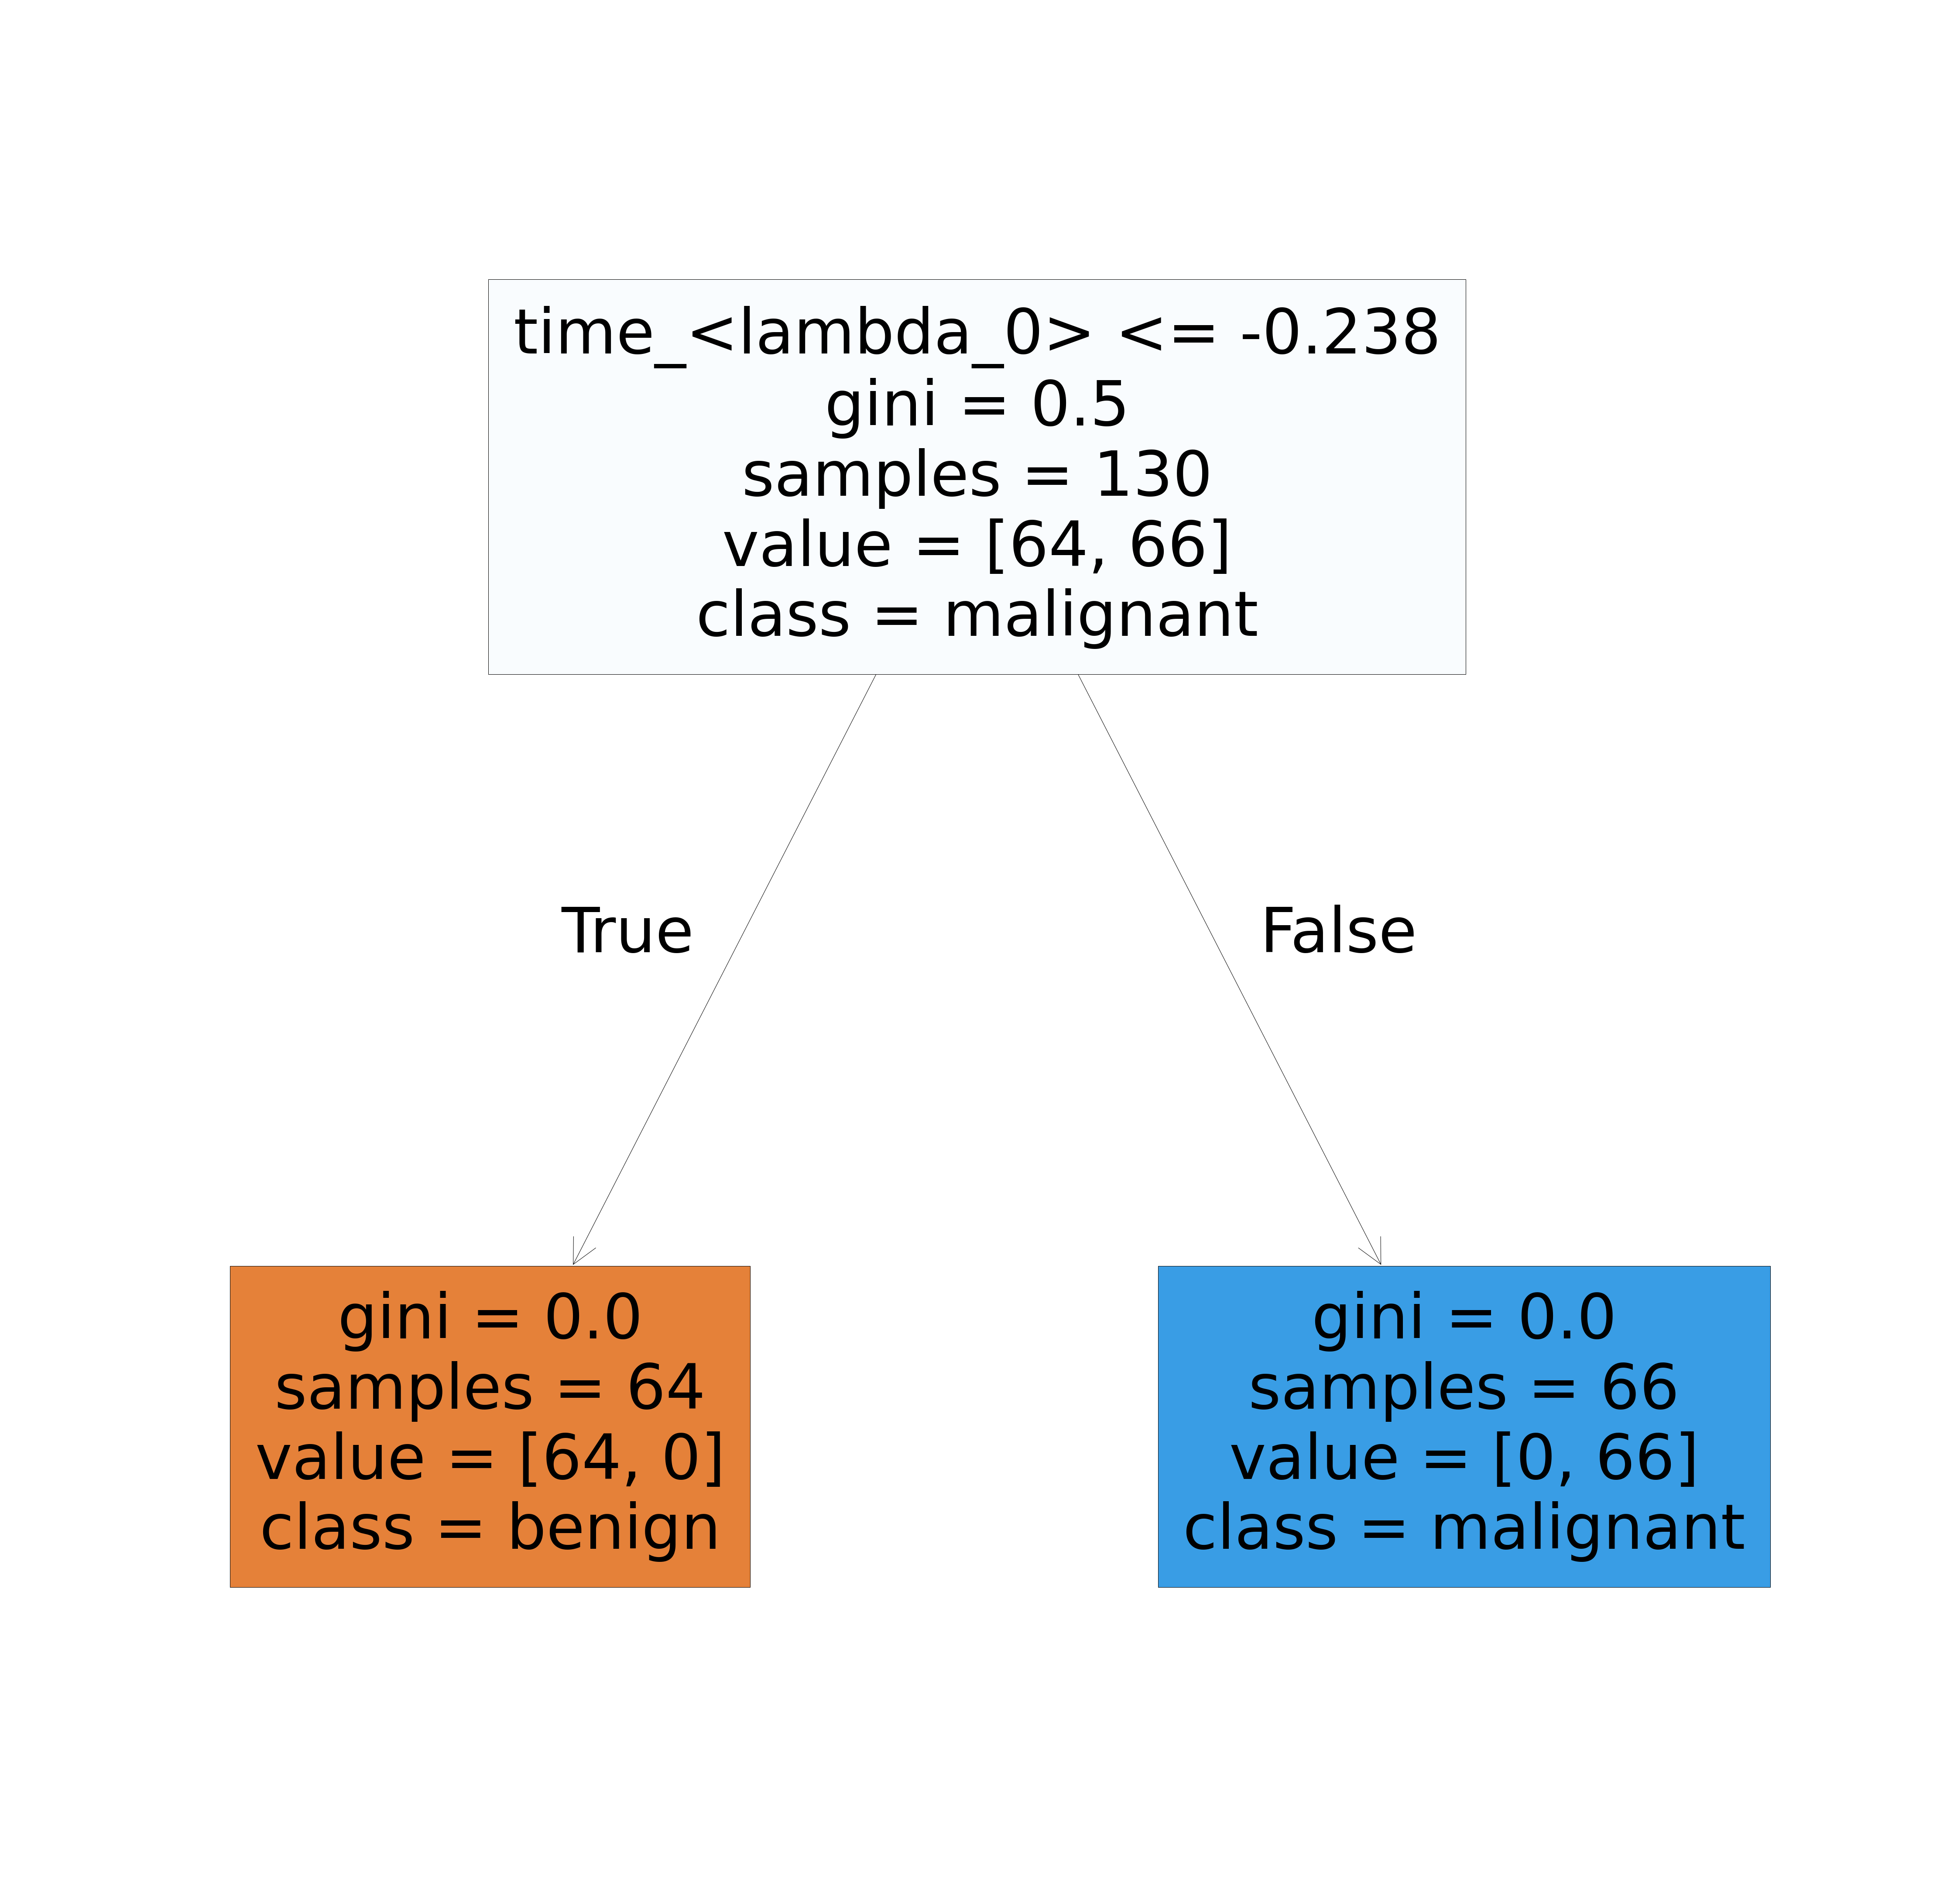

In [19]:
trustee = ClassificationTrustee(expert=clf)
X_scaled = scaler.transform(X)
trustee.fit(X_scaled, y, num_samples=len(X) // 2, num_iter=10, train_size=0.99)

# Display Trustee Results
_, dt, _, score = trustee.explain()
print(f"Training score of pruned DT: {score}")
dt_y_pred = dt.predict(X_train)
print("Model explanation global fidelity report:")
print(classification_report(clf.predict(X_train_scaled), dt_y_pred))
print("Model explanation score report:")
print(classification_report(y_train, dt_y_pred))

# plot a tree
fig = plt.figure(figsize=(80,80))
plot_tree(dt, feature_names=flows.columns, class_names=['benign', 'malignant'], filled=True, max_depth=7)